In [1]:
import pandas as pd
from feature_creation import data_copy
from sklearn.model_selection import KFold, cross_val_score, train_test_split, cross_val_predict
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures, Normalizer,StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from os import cpu_count
import numpy as np
import seaborn as sns

# Build model for Logistic lasso regression

In [2]:
data_copy['increase_stock'] = data_copy['increase_stock'].apply(lambda entity: 1 if entity == 'high_bike_demand' else 0)
data_copy['increase_stock'] = data_copy['increase_stock'].astype('int')
data_copy = data_copy.drop('holiday',axis=1)
data_copy = data_copy.drop('snowdepth',axis=1)
data_copy = data_copy.drop('visibility',axis=1)
data_copy.describe()

,weekday,summertime,temp,dew,humidity,precip,windspeed,cloudcover,increase_stock,daytime,rushhour,weather_score,weather_score_daytime
count,1600.000000,1600.00000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000
mean,0.710000,0.64375,15.210313,7.750750,63.927844,0.122042,13.082500,64.322375,0.180000,0.543750,0.205625,0.180000,0.127378
std,0.453904,0.47904,9.264785,10.026459,19.079419,0.920600,7.756652,32.748869,0.384308,0.498238,0.404284,0.184322,0.189459
min,0.000000,0.00000,-9.100000,-18.400000,15.850000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.239787,-0.160192
25%,0.000000,0.00000,7.700000,-0.800000,47.845000,0.000000,7.500000,28.800000,0.000000,0.000000,0.000000,0.049945,0.000000
50%,1.000000,1.00000,15.500000,8.300000,65.175000,0.000000,12.300000,79.300000,0.000000,1.000000,0.000000,0.154343,0.000000
75%,1.000000,1.00000,23.200000,16.800000,79.955000,0.000000,17.600000,92.800000,0.000000,1.000000,0.000000,0.278779,0.225751
max,1.000000,1.00000,35.600000,24.300000,99.890000,25.871000,43.800000,100.000000,1.000000,1.000000,1.000000,0.956538,0.956538


In [3]:
data_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600 entries, 0 to 1599
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   hour_of_day            1600 non-null   category
 1   day_of_week            1600 non-null   category
 2   month                  1600 non-null   category
 3   weekday                1600 non-null   int64   
 4   summertime             1600 non-null   int64   
 5   temp                   1600 non-null   float64 
 6   dew                    1600 non-null   float64 
 7   humidity               1600 non-null   float64 
 8   precip                 1600 non-null   float64 
 9   windspeed              1600 non-null   float64 
 10  cloudcover             1600 non-null   float64 
 11  increase_stock         1600 non-null   int64   
 12  daytime                1600 non-null   int64   
 13  rushhour               1600 non-null   int64   
 14  weather_score          1600 non-null   f

In [32]:
X_train, X_test, y_train, y_test = train_test_split(data_copy.drop('increase_stock',axis=1), data_copy['increase_stock'], test_size=0.1, random_state=123) 

preprocessor = ColumnTransformer([
    ('poly', PolynomialFeatures(include_bias=False), list(X_train.select_dtypes(include='number').columns)),
    ('cat',LabelEncoder(), list(X_train.select_dtypes(include='category').columns))
],
    remainder='passthrough')
logreg_model = Pipeline([
    ('preprocessor', preprocessor),
    ('norm', Normalizer()),
    ('classifier', LogisticRegression(penalty='l1',C=.66,solver='liblinear',max_iter=10000))
])

In [33]:
kf = KFold(n_splits=10, shuffle=True, random_state=123)
cross_val_results = cross_val_score(logreg_model, X_train, y_train, cv=kf, scoring='accuracy',n_jobs=cpu_count()) #run in parallel

# Print the cross-validation results
print(f'Cross-validation results: {cross_val_results}')
print(f'Mean accuracy: {np.mean(cross_val_results)}')

Cross-validation results: [0.85416667 0.82638889 0.84722222 0.88888889 0.86805556 0.86805556
 0.82638889 0.88194444 0.77777778 0.77083333]
Mean accuracy: 0.8409722222222221


In [34]:
logreg_model.fit(X_train,y_train)
processed_names = logreg_model[:-1].get_feature_names_out()
logreg_coefs = logreg_model.named_steps["classifier"].coef_[0]
print(f'col len: {len(processed_names)} coef len: {len(logreg_coefs)}')
for item in zip(processed_names,logreg_coefs):
    print(f'{item[0]} = {item[1]}')

col len: 133 coef len: 133
poly__weekday = 0.0
poly__summertime = 0.0
poly__temp = 0.0
poly__dew = 0.0
poly__humidity = 0.0
poly__precip = 0.0
poly__windspeed = 0.0
poly__cloudcover = 0.0
poly__daytime = 0.0
poly__rushhour = 0.0
poly__weather_score = 0.0
poly__weather_score_daytime = 0.0
poly__weekday^2 = 0.0
poly__weekday summertime = 0.0
poly__weekday temp = 0.0
poly__weekday dew = 0.0
poly__weekday humidity = 0.0
poly__weekday precip = 0.0
poly__weekday windspeed = 0.0
poly__weekday cloudcover = 0.0
poly__weekday daytime = 0.0
poly__weekday rushhour = 0.0
poly__weekday weather_score = 0.0
poly__weekday weather_score_daytime = 0.0
poly__summertime^2 = 0.0
poly__summertime temp = 0.0
poly__summertime dew = 0.0
poly__summertime humidity = 0.0
poly__summertime precip = 0.0
poly__summertime windspeed = 0.0
poly__summertime cloudcover = 0.0
poly__summertime daytime = 0.0
poly__summertime rushhour = 0.0
poly__summertime weather_score = 0.0
poly__summertime weather_score_daytime = 0.0
poly_

### Now lets optimize the C (lambda) and see if we can improve the score

In [37]:
# NOTE! very expensive code. Uncomment for very long run time
mean_cross_val_scores = []
for i in range(1,100):
    result = {}
    C_temp = i/100
    
    logreg_model = Pipeline([
        ('preprocessor', preprocessor),
        ('norm', StandardScaler()),
        ('classifier', LogisticRegression(penalty='l1',C=C_temp,solver='liblinear',max_iter=10000))
    ])
    cvs = cross_val_score(logreg_model, X_train, y_train, cv=kf, scoring='accuracy',n_jobs=cpu_count()) #run in parallel
    result['cvs'] = cvs
    result['mean_perf'] = np.mean(cvs)
    result['reg_val'] = C_temp
    mean_cross_val_scores.append(result)
performance_df = pd.DataFrame(mean_cross_val_scores)

cvs          [0.9444444444444444, 0.9305555555555556, 0.888...
mean_perf                                             0.915972
reg_val                                                   0.14
Name: 13, dtype: object


<Axes: ylabel='mean_perf'>

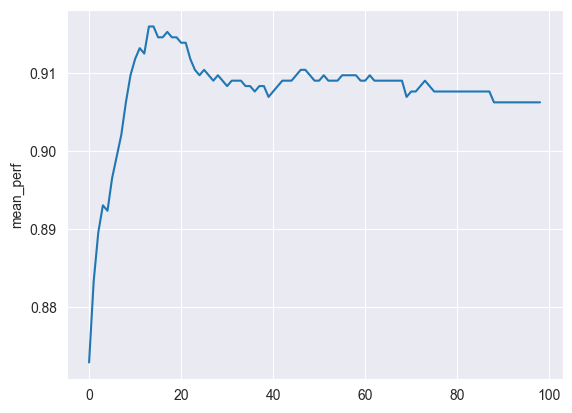

In [45]:
print(performance_df.loc[performance_df['mean_perf'].idxmax()])
# print(performance_df[55:70])
sns.lineplot(performance_df['mean_perf'])

# use C=.99 to retrain the model
### lowest optimal C (1/lambda) is .77
### highest optimal C is .99

In [46]:
log_lasso_model = Pipeline([
    ('preprocessor', preprocessor),
    # ('norm', StandardScaler()),
    ('classifier', LogisticRegression(penalty='l1',C=.14,solver='liblinear',max_iter=10000))
])
log_lasso_model.fit(X_train,y_train)
processed_names = log_lasso_model[:-1].get_feature_names_out()
logreg_coefs = log_lasso_model.named_steps["classifier"].coef_[0]
print(f'col len: {len(processed_names)} coef len: {len(logreg_coefs)}')
for item in zip(processed_names,logreg_coefs):
    print(f'{item[0]} = {item[1]}')

col len: 133 coef len: 133
poly__weekday = 0.0
poly__summertime = 0.0
poly__temp = 0.3779750289733303
poly__dew = 0.0
poly__humidity = 0.0
poly__precip = 0.0
poly__windspeed = 0.0
poly__cloudcover = 0.0
poly__daytime = 0.21712887689754032
poly__rushhour = 0.0
poly__weather_score = 0.3533203674742245
poly__weather_score_daytime = 0.16189685093523243
poly__weekday^2 = 0.0
poly__weekday summertime = 0.0
poly__weekday temp = 0.0
poly__weekday dew = 0.0
poly__weekday humidity = 0.0
poly__weekday precip = 0.0
poly__weekday windspeed = -0.12302521444741377
poly__weekday cloudcover = 0.0
poly__weekday daytime = 0.0
poly__weekday rushhour = 0.372125807216174
poly__weekday weather_score = 0.0
poly__weekday weather_score_daytime = -0.8663010308923772
poly__summertime^2 = 0.0
poly__summertime temp = 0.0
poly__summertime dew = 0.0
poly__summertime humidity = 0.0
poly__summertime precip = 0.0
poly__summertime windspeed = 0.0
poly__summertime cloudcover = 0.0
poly__summertime daytime = 0.480677624197

In [47]:
test_df = pd.DataFrame(
    {'y_hat': log_lasso_model.predict(X_test),'y_true': y_test}
)
test_df['success_rate'] = (test_df['y_hat'] == test_df['y_true'])
test_df['success_rate'] = test_df['success_rate'].astype('int')

In [48]:
test_df.describe()

,y_hat,y_true,success_rate
count,160.000000,160.000000,160.000000
mean,0.156250,0.181250,0.862500
std,0.364232,0.386435,0.345456
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000
50%,0.000000,0.000000,1.000000
75%,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000


In [49]:
print(f'model is correct {test_df["success_rate"].mean()*100}% of the time (E new)')
print(f'supposed performance {performance_df["mean_perf"].max()*100}%')
print(f'supposed range (from k=5 split) [{np.min(cross_val_results)*100} - {np.max(cross_val_results)*100}]%')

model is correct 86.25% of the time (E new)
supposed performance 91.59722222222223%
supposed range (from k=5 split) [77.08333333333334 - 88.88888888888889]%


In [50]:
y_hats = cross_val_predict(log_lasso_model,X=data_copy.drop('increase_stock',axis=1),y=data_copy['increase_stock'],cv=160, n_jobs=cpu_count())

In [51]:
print(classification_report(data_copy['increase_stock'],y_hats))

              precision    recall  f1-score   support

           0       0.93      0.96      0.94      1312
           1       0.79      0.66      0.72       288

    accuracy                           0.91      1600
   macro avg       0.86      0.81      0.83      1600
weighted avg       0.90      0.91      0.90      1600


In [52]:
log_lasso_model.fit(data_copy.drop('increase_stock',axis=1),data_copy['increase_stock'])
processed_names = log_lasso_model[:-1].get_feature_names_out()
logreg_coefs = log_lasso_model.named_steps["classifier"].coef_[0]
print(f'col len: {len(processed_names)} coef len: {len(logreg_coefs)}')
for item in zip(processed_names,logreg_coefs):
    print(f'{item[0]} = {item[1]}')

col len: 133 coef len: 133
poly__weekday = 0.0
poly__summertime = 0.0
poly__temp = 0.30659176217629497
poly__dew = 0.0
poly__humidity = 0.0
poly__precip = 0.0
poly__windspeed = 0.0
poly__cloudcover = 0.0
poly__daytime = 0.42678139209149024
poly__rushhour = 0.0
poly__weather_score = 0.3692901163007276
poly__weather_score_daytime = 0.08251292882973968
poly__weekday^2 = 0.0
poly__weekday summertime = 0.0
poly__weekday temp = 0.0
poly__weekday dew = 0.0
poly__weekday humidity = 0.0
poly__weekday precip = 0.0
poly__weekday windspeed = -0.1332084652780254
poly__weekday cloudcover = 0.0
poly__weekday daytime = 0.0
poly__weekday rushhour = 0.47007623855929376
poly__weekday weather_score = 0.0
poly__weekday weather_score_daytime = -0.7899709686625175
poly__summertime^2 = 0.0
poly__summertime temp = 0.0
poly__summertime dew = 0.0
poly__summertime humidity = 0.0
poly__summertime precip = 0.0
poly__summertime windspeed = 0.0
poly__summertime cloudcover = 0.0
poly__summertime daytime = 0.3925854030

In [65]:
pd.DataFrame(log_lasso_model[1].transform(
    log_lasso_model[0].transform(data_copy.drop('increase_stock',axis=1))
),columns=list(log_lasso_model[:-1].get_feature_names_out()))

,poly__weekday,poly__summertime,poly__temp,poly__dew,poly__humidity,poly__precip,poly__windspeed,poly__cloudcover,poly__daytime,poly__rushhour,...,cat__month_3,cat__month_4,cat__month_5,cat__month_6,cat__month_7,cat__month_8,cat__month_9,cat__month_10,cat__month_11,cat__month_12
0,-1.564697,-1.344254,-2.419627,-2.269781,-0.537283,-0.132609,0.414935,-0.999503,-1.091687,-0.508774,...,-0.318072,-0.309662,-0.3011,-0.306012,-0.304789,-0.286028,-0.298624,-0.283463,-0.310872,-0.304789
1,0.639101,-1.344254,-1.782607,-2.050293,-1.203654,-0.132609,1.395045,0.652979,-1.091687,-0.508774,...,-0.318072,-0.309662,-0.3011,-0.306012,-0.304789,-0.286028,-0.298624,-0.283463,-0.310872,-0.304789
2,0.639101,0.743907,1.262128,1.401656,0.496090,-0.132609,-1.687144,0.512472,-1.091687,-0.508774,...,-0.318072,-0.309662,-0.3011,-0.306012,-0.304789,3.496161,-0.298624,-0.283463,-0.310872,-0.304789
3,-1.564697,-1.344254,-1.307542,-1.172340,-0.219564,-0.132609,0.788924,-1.964724,-1.091687,-0.508774,...,-0.318072,-0.309662,-0.3011,-0.306012,-0.304789,-0.286028,-0.298624,-0.283463,-0.310872,-0.304789
4,0.639101,-1.344254,-0.379006,-1.910618,-2.370721,-0.132609,-0.333044,-0.602419,0.916013,1.965508,...,3.143939,-0.309662,-0.3011,-0.306012,-0.304789,-0.286028,-0.298624,-0.283463,-0.310872,-0.304789
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,-1.564697,0.743907,0.679093,1.162214,1.245299,-0.132609,-0.320148,-1.219427,-1.091687,-0.508774,...,-0.318072,-0.309662,-0.3011,3.267848,-0.304789,-0.286028,-0.298624,-0.283463,-0.310872,-0.304789
1596,0.639101,0.743907,0.862641,1.232051,0.970047,2.276357,-0.423317,0.848466,0.916013,-0.508774,...,-0.318072,-0.309662,-0.3011,3.267848,-0.304789,-0.286028,-0.298624,-0.283463,-0.310872,-0.304789
1597,0.639101,0.743907,-0.141474,-0.992759,-1.625182,-0.132609,0.659963,0.457491,0.916013,-0.508774,...,3.143939,-0.309662,-0.3011,-0.306012,-0.304789,-0.286028,-0.298624,-0.283463,-0.310872,-0.304789
1598,-1.564697,0.743907,-0.379006,-1.701107,-2.193511,-0.132609,-0.939165,-1.219427,0.916013,-0.508774,...,3.143939,-0.309662,-0.3011,-0.306012,-0.304789,-0.286028,-0.298624,-0.283463,-0.310872,-0.304789


In [66]:
log_lasso_model[0]

ColumnTransformer(remainder='passthrough',
                  transformers=[('poly', PolynomialFeatures(include_bias=False),
                                 ['weekday', 'summertime', 'temp', 'dew',
                                  'humidity', 'precip', 'windspeed',
                                  'cloudcover', 'daytime', 'rushhour',
                                  'weather_score', 'weather_score_daytime']),
                                ('cat', OneHotEncoder(),
                                 ['hour_of_day', 'day_of_week', 'month'])])